# Simple Jax (Flax) NN from Scratch

Flax is a deep learning library designed for Jax. It provides a set of tools that make defining models and handling initialization and paramater updates much easier. In this notebook we show how to use Flax to train a simple neural network.


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
import flax
import flax.linen as nn
import jax
from jax import random
from jax import vmap
from jax import grad

In [36]:
data_df = pd.read_csv('./digit-recognizer/train.csv')

In [37]:
np.random.shuffle(data_df.values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)


X_train = X[1000:]
X_train = X_train / 255.
Y_train = Y[1000:]

X_val = X[:1000]
X_val = X_val / 255.
Y_val = Y[:1000]

Our NN will have a simple two-layer architecture. Input layer $A^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $A^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $A^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.


**Forward propagation**

Input Layer:    
$$X = A^{[0]}$$

First Hidden Layer:
$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]})$$

Second Hidden Layer:
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

Loss Function (Categorical Cross Entropy):  
$$L(y, a^{[2]}) = -\sum_{j = 1}^{C}y_{j} \cdot\ log(a^{[2]})$$ 
C is the number of classes, which is 10 in this case. 

Cost Function:
$$J(W, b) = -\frac{1}{m} \sum_{i = 1}^{m} L(y^{i}, a^{[2](i)})$$ 
$$J(W, b) = -\frac{1}{m} \sum_{i = 1}^{m} \sum_{j = 1}^{C}y^{i}_{j}\cdot\log(a^{[2](i)})$$ 
The cost function is the average of the losses over all the samples.

Derivatives:    
For detailed derivation of $dZ^{[2]}$ see: [derivation-of-categorical-cross-entropy-loss](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1)    
For more details on the rest of the derivations see: [backpropagation-intuition](https://www.youtube.com/watch?v=yXcQ4B-YSjQ&list=PLkDaE6sCZn6Ec-XTbcX1uRg2_u4xOEky0&index=34&ab_channel=DeepLearningAI)
$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \sum_{i = 1}^{m} {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \sum_{i = 1}^{m} {dZ^{[1]}}$$

**Gradient Descent (parameter updates)**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

The layers and activation functions can now be defined using Flax's Module class. No need to explicitly specify the weights and biases of each layer.

In [38]:
class _forward_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        mlp = nn.Sequential([
            nn.Dense(10), jax.nn.relu,
            nn.Dense(10), jax.nn.softmax        
        ])
        return mlp(x)

An instance of the Module object is created, which then will provide access to the .init and .apply methods needed for initializing the weights and performing a forward pass.

In [39]:
forward_fn = _forward_fn()

The models layers shown below, are the same as used in previous notebooks.

In [40]:
dummy_x = X_train[:5]
rng_key = random.PRNGKey(64)

initial_params = forward_fn.init(rng_key, dummy_x)

print(forward_fn.tabulate(rng_key, dummy_x))


                              _forward_fn Summary                               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path         ┃ module      ┃ inputs         ┃ outputs       ┃ params         ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│              │ _forward_fn │ float32[5,784] │ float32[5,10] │                │
├──────────────┼─────────────┼────────────────┼───────────────┼────────────────┤
│ Sequential_0 │ Sequential  │ float32[5,784] │ float32[5,10] │                │
├──────────────┼─────────────┼────────────────┼───────────────┼────────────────┤
│ Dense_0      │ Dense       │ float32[5,784] │ float32[5,10] │ bias:          │
│              │             │                │               │ float32[10]    │
│              │             │                │               │ kernel:        │
│              │             │                │               │ float32[784,1… │
│              │           

The model can process a batch of any size.

In [41]:
preds = forward_fn.apply(initial_params, X_train[:5])
print(preds)

[[0.10030214 0.10537831 0.08858463 0.10541832 0.10143708 0.10518872
  0.09409714 0.09923813 0.10003395 0.10032155]
 [0.0991649  0.10622651 0.09852392 0.09719839 0.09627932 0.10907576
  0.09923974 0.09643156 0.09323804 0.1046218 ]
 [0.10084233 0.09057501 0.10379352 0.10544842 0.10453036 0.10527998
  0.08602746 0.10307699 0.1001559  0.10027014]
 [0.09923845 0.08956067 0.11629339 0.11504055 0.09972727 0.13689978
  0.0800038  0.09305066 0.08010798 0.09007746]
 [0.09335489 0.12094128 0.08262277 0.089471   0.09674408 0.11873088
  0.07608679 0.08502708 0.0870592  0.14996204]]


The forward pass performed in the loss function now needs the .apply method. The explicit weights, biases and gradients have been replaced by params and grads in the update_params function. This saves a lot of code on more complex models.

In [42]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

def loss_fn(params, X, Y):
    A2 = forward_fn.apply(params, X)
    one_hot_Y = one_hot(Y, 10)
    loss = -jnp.sum(one_hot_Y * jnp.log(A2)) / m
    return loss


def update_rule(param, update):
    return param - 0.1 * update

def update_params(params, alpha, X, Y):
    grads = grad(loss_fn, argnums=0)(params, X, Y)
    params = jax.tree_util.tree_map(update_rule, params, grads)
    return params


The initialization function has been removed since Flax handles the initialization using the .init method.

In [43]:
def get_predictions(A2):
    return jnp.argmax(A2, axis=1)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, alpha, iterations):
    rng = jax.random.PRNGKey(42)
    params = forward_fn.init(rng, X)
    for i in range(iterations):
        params = update_params(params, alpha, X, Y)
        if i % 10 == 0:
            print("Iteration: ", i)
            A2 = forward_fn.apply(params, X)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return params

In [44]:
params = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[7 7 8 ... 6 2 8] [6 1 6 ... 0 3 8]
0.10356097
Iteration:  10
[6 7 6 ... 3 3 8] [6 1 6 ... 0 3 8]
0.36341462
Iteration:  20
[6 7 6 ... 3 3 8] [6 1 6 ... 0 3 8]
0.45492682
Iteration:  30
[6 1 6 ... 3 3 8] [6 1 6 ... 0 3 8]
0.5245122
Iteration:  40
[6 1 6 ... 3 3 8] [6 1 6 ... 0 3 8]
0.553561
Iteration:  50
[6 1 6 ... 3 3 8] [6 1 6 ... 0 3 8]
0.59165853
Iteration:  60
[6 1 6 ... 3 3 8] [6 1 6 ... 0 3 8]
0.63231707
Iteration:  70
[6 1 6 ... 3 3 8] [6 1 6 ... 0 3 8]
0.6631707
Iteration:  80
[6 1 6 ... 3 3 8] [6 1 6 ... 0 3 8]
0.6844634
Iteration:  90
[6 1 6 ... 3 3 8] [6 1 6 ... 0 3 8]
0.70258534
Iteration:  100
[6 1 6 ... 3 3 8] [6 1 6 ... 0 3 8]
0.71812195
Iteration:  110
[6 1 6 ... 3 3 8] [6 1 6 ... 0 3 8]
0.73312193
Iteration:  120
[6 1 6 ... 3 3 8] [6 1 6 ... 0 3 8]
0.7464634
Iteration:  130
[6 1 6 ... 3 3 8] [6 1 6 ... 0 3 8]
0.7621219
Iteration:  140
[6 1 6 ... 3 3 8] [6 1 6 ... 0 3 8]
0.77560973
Iteration:  150
[6 1 6 ... 0 3 8] [6 1 6 ... 0 3 8]
0.788
Iteration:  160

In [45]:
def make_predictions(X, params):
    rng = jax.random.PRNGKey(42)
    A2 = forward_fn.apply(params, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, params):
    current_image = X_train[None, index]
    prediction = make_predictions(X_train[None, index], params)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [6]
Label:  6


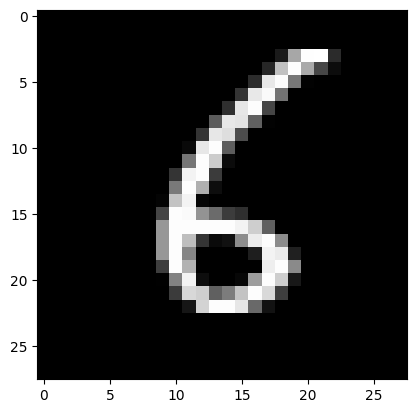

Prediction:  [1]
Label:  1


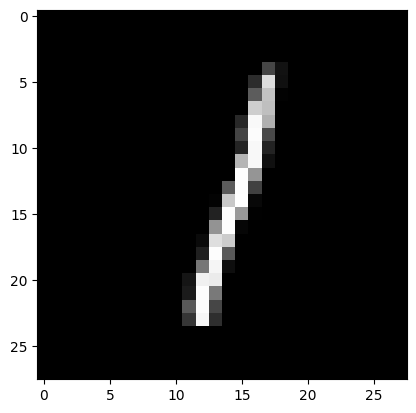

Prediction:  [6]
Label:  6


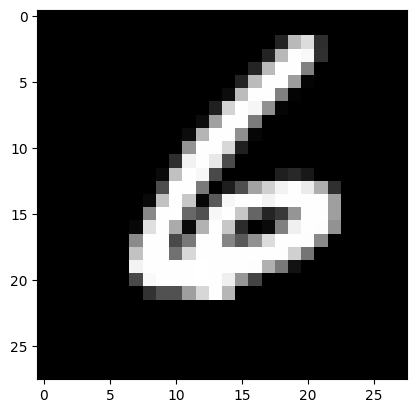

Prediction:  [3]
Label:  3


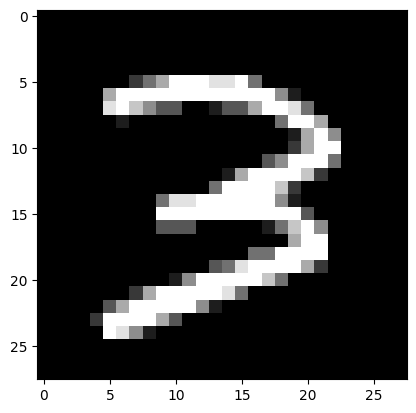

In [46]:
test_prediction(0, params)
test_prediction(1, params)
test_prediction(2, params)
test_prediction(3, params)

In [47]:
val_predictions = make_predictions(X_val, params)
get_accuracy(val_predictions, Y_val)

[5 4 5 8 7 2 0 9 3 5 4 4 7 9 8 1 8 6 9 9 1 5 7 7 2 6 6 4 9 0 2 9 5 7 2 1 4
 1 5 3 1 4 7 1 1 1 1 1 9 7 4 1 4 1 1 8 3 6 1 7 1 3 9 4 3 6 0 0 3 6 3 2 1 4
 7 2 2 5 9 8 3 9 1 8 7 4 9 2 1 5 1 4 3 9 8 5 8 4 7 7 9 6 5 7 7 1 8 1 8 7 2
 3 8 2 1 6 4 5 7 6 2 6 5 6 4 1 1 1 4 7 1 7 7 6 7 9 9 8 8 4 2 7 4 9 9 2 1 9
 1 4 3 4 6 8 7 8 9 0 5 0 4 2 3 1 3 1 4 9 5 4 0 3 7 9 6 9 6 9 7 3 3 0 1 8 0
 5 8 0 4 4 0 6 8 7 1 8 0 0 1 7 9 1 5 7 5 9 6 0 7 9 0 3 7 6 9 9 4 1 7 1 8 5
 3 7 7 9 6 7 4 2 2 2 8 5 7 1 3 8 3 2 8 0 2 8 9 4 9 0 6 7 9 6 9 0 3 8 8 3 5
 5 0 2 4 9 4 9 5 8 1 6 3 6 9 4 5 3 3 7 1 1 5 8 3 4 2 1 8 9 4 9 2 2 7 2 1 2
 8 5 2 5 2 8 5 5 7 9 3 2 7 9 3 8 4 6 4 4 4 1 7 5 0 4 9 3 3 0 2 2 6 6 9 8 1
 2 6 6 3 9 2 8 0 1 7 0 4 7 3 2 9 4 9 4 5 3 2 8 7 6 6 7 7 8 8 2 0 7 8 0 5 2
 7 7 1 5 7 2 3 4 1 4 7 8 4 2 0 9 3 8 0 6 1 8 9 9 0 0 0 8 9 2 7 9 3 8 8 0 0
 4 5 7 8 2 1 3 5 9 4 2 9 9 1 3 0 3 7 3 0 2 8 2 4 0 1 6 9 9 9 3 1 1 8 6 7 0
 1 9 7 8 1 7 9 7 9 9 7 4 5 8 2 4 7 0 6 3 7 6 7 4 1 3 8 1 8 8 6 4 0 3 1 8 1
 1 6 8 2 7 4 7 6 1 6 3 8 

DeviceArray(0.87100005, dtype=float32)

No loss in accuracy during training or inferencing compared to other methods.

### Conclusion

Flax provides powerful tools that make defining model architecture and intialization simple. As shown in this notebook, this saves a lot of time and complexity in the code. Although very similar to the Haiku version, there are some minor differences in how the model is defined.